In [27]:
#Imports
import numpy as np
import pandas as pd
import tensorflow.keras.backend as k
from sklearn.preprocessing import MinMaxScaler,  RobustScaler
from tensorflow import keras
from tensorflow.keras import Sequential, layers, optimizers, losses, regularizers
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import Huber



In [28]:
import numpy as np
import pandas as pd

# Read a specific sheet
df = pd.read_excel(r"C:\Users\William\OneDrive\Documents\Data Cleaning\LARUAN.xlsx", 
                   sheet_name='04-VAL04H-PM-1 MIRANDA-PSAN_Pre')

df.head(20)

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
5,PMP,04-VAL04H-PM-1 MIRANDA-PSAN_Pressure,DATE/TIME,DATA (psi)
6,NaN,NaN,2022-01-01 00:00:00,[-11057] Not Enough Values For Calculation
7,NaN,NaN,2022-01-01 00:15:00,[-11057] Not Enough Values For Calculation
8,NaN,NaN,2022-01-01 00:30:00,[-11057] Not Enough Values For Calculation
9,NaN,NaN,2022-01-01 00:45:00,[-11057] Not Enough Values For Calculation


In [29]:
# Don't use this unless you're gonna change your prv dataset.
# to clean

df.drop(['Unnamed: 1', 'Unnamed: 0'], axis=1, inplace=True)
df.to_csv('semicleaned3.csv', index=False)
df.head(100)

,Unnamed: 2,Unnamed: 3
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
95,2022-01-01 22:15:00,[-11057] Not Enough Values For Calculation
96,2022-01-01 22:30:00,[-11057] Not Enough Values For Calculation
97,2022-01-01 22:45:00,[-11057] Not Enough Values For Calculation
98,2022-01-01 23:00:00,[-11057] Not Enough Values For Calculation


In [30]:
import numpy as np
import pandas as pd
#Cleaning changing Not enough values to NaN
df3 = pd.read_csv("semicleaned3.csv", skiprows=6)
df3.columns = ['DATE/TIME', 'DATA (psi)']
df3.replace('[-11057] Not Enough Values For Calculation', np.nan, inplace=True)
#changing data types
df3['DATA (psi)'] = pd.to_numeric(df3['DATA (psi)'], errors='coerce')
df3['DATE/TIME'] = pd.to_datetime(df3['DATE/TIME'], errors='coerce')
print(df3.dtypes)

df3

DATE/TIME     datetime64[ns]
DATA (psi)           float64
dtype: object


,DATE/TIME,DATA (psi)
0,2022-01-01 00:00:00,NaN
1,2022-01-01 00:15:00,NaN
2,2022-01-01 00:30:00,NaN
3,2022-01-01 00:45:00,NaN
4,2022-01-01 01:00:00,NaN
...,...,...
101659,2024-11-24 22:45:00,7.81
101660,2024-11-24 23:00:00,9.23
101661,2024-11-24 23:15:00,9.94
101662,2024-11-24 23:30:00,8.52


In [31]:
#Looking for attributes to clean & analyze
print(np.isinf(df3).sum())
print(df3.isna().sum()) 
print(df3.dtypes)
print(df3['DATA (psi)'].describe())
df3.isnull().sum()

DATE/TIME     0
DATA (psi)    0
dtype: int64
DATE/TIME        0
DATA (psi)    8832
dtype: int64
DATE/TIME     datetime64[ns]
DATA (psi)           float64
dtype: object
count    92832.000000
mean        14.180673
std          4.890797
min         -2.840000
25%         10.650000
50%         13.490000
75%         16.330000
max         42.599998
Name: DATA (psi), dtype: float64


DATE/TIME        0
DATA (psi)    8832
dtype: int64

In [32]:
df3 = df3.copy()  # Creates a separate copy
df3.index = pd.to_datetime(df3.index)  # Convert index to DateTimeIndex

# Replace values above 30 with NaN
df3.loc[df3['DATA (psi)'] > 30, 'DATA (psi)'] = np.nan

# Now, interpolate using time
#df3['DATA (psi)'] = df3['DATA (psi)'].interpolate(method='time')

# Apply rolling median filtering
df3['DATA (psi)'] = df3['DATA (psi)'].rolling(window=5, center=True).median()


#dropping na passing to df3_cleaned
df3['DATA (psi)'] = df3['DATA (psi)'].abs()
df3_cleaned = df3.dropna()
  # Replaces negatives with NaN (or you can drop rows if needed)
df3_cleaned



,DATE/TIME,DATA (psi)
1970-01-01 00:00:00.000007107,2022-03-16 00:45:00,19.879999
1970-01-01 00:00:00.000007108,2022-03-16 01:00:00,19.879999
1970-01-01 00:00:00.000007109,2022-03-16 01:15:00,19.879999
1970-01-01 00:00:00.000007110,2022-03-16 01:30:00,19.879999
1970-01-01 00:00:00.000007111,2022-03-16 01:45:00,19.879999
...,...,...
1970-01-01 00:00:00.000101657,2024-11-24 22:15:00,7.810000
1970-01-01 00:00:00.000101658,2024-11-24 22:30:00,7.810000
1970-01-01 00:00:00.000101659,2024-11-24 22:45:00,8.520000
1970-01-01 00:00:00.000101660,2024-11-24 23:00:00,8.520000


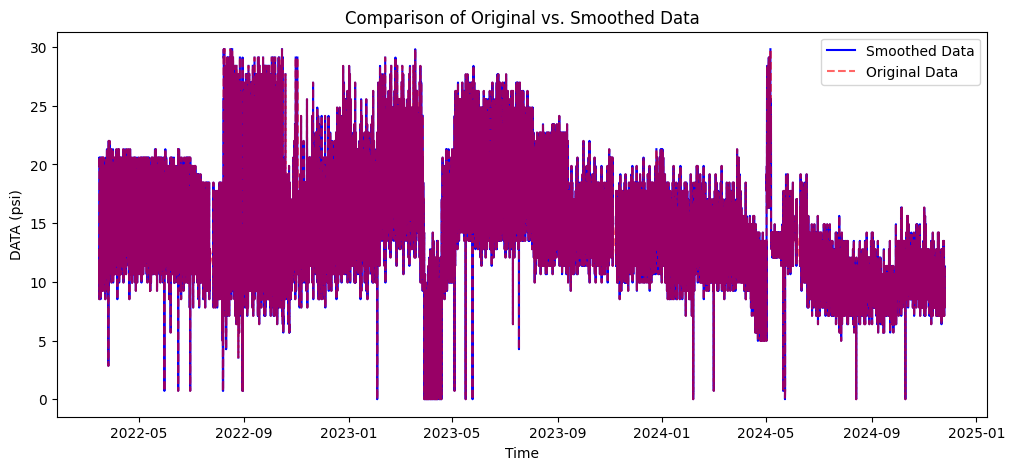

In [33]:
plt.figure(figsize=(12, 5))
plt.plot(df3['DATE/TIME'], df3['DATA (psi)'], label='Smoothed Data', color='blue')
plt.plot(df3_cleaned['DATE/TIME'], df3_cleaned['DATA (psi)'], label='Original Data', linestyle='dashed', color='red', alpha=0.6)
plt.legend()
plt.title('Comparison of Original vs. Smoothed Data')
plt.xlabel('Time')
plt.ylabel('DATA (psi)')
plt.show()

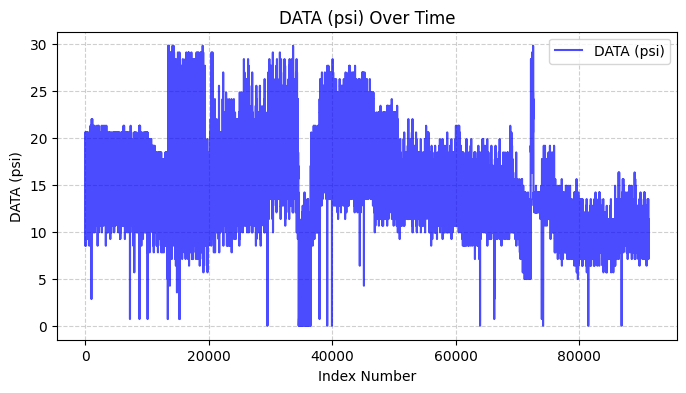

In [34]:
#visualizing my dataframe
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 4))

# Reset index so x-axis uses simple index numbers
df3_cleaned_reset = df3_cleaned.reset_index()

# Plot using numerical indices on the x-axis
plt.plot(df3_cleaned_reset.index, df3_cleaned_reset['DATA (psi)'], color='blue', alpha=0.7, label='DATA (psi)')

# Formatting
plt.xlabel('Index Number')
plt.ylabel('DATA (psi)')
plt.title('DATA (psi) Over Time')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()



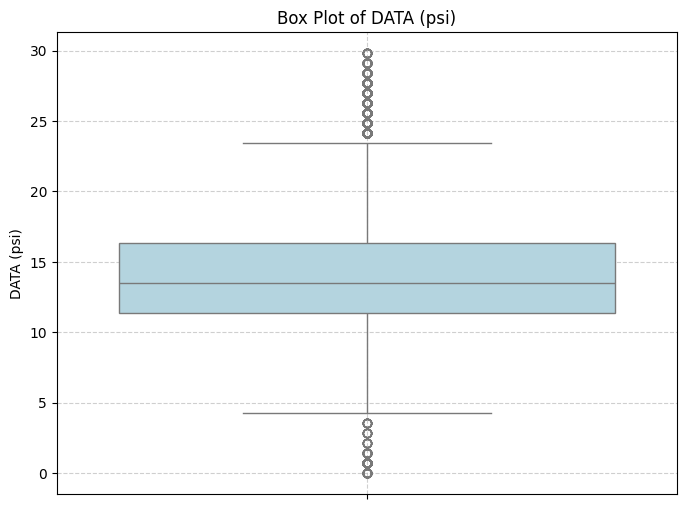

In [35]:
#boxplot
plt.show()

plt.figure(figsize=(8, 6))

# Create a box plot for DATA (psi)
sns.boxplot(y=df3_cleaned['DATA (psi)'], color='lightblue')

# Formatting
plt.ylabel('DATA (psi)')
plt.title('Box Plot of DATA (psi)')
plt.grid(True, linestyle='--', alpha=0.6)

plt.show()

In [36]:
#double check and analyze
print(df3_cleaned.dtypes)
print(df3_cleaned['DATA (psi)'].describe())

#passing df3_cleaned to data
data = df3_cleaned[['DATE/TIME', 'DATA (psi)']].copy()

data['DATE/TIME'] = pd.to_datetime(data['DATE/TIME'])
data.set_index('DATE/TIME', inplace=True)
data

DATE/TIME     datetime64[ns]
DATA (psi)           float64
dtype: object
count    91291.000000
mean        13.981052
std          4.295753
min          0.000000
25%         11.360000
50%         13.490000
75%         16.330000
max         29.820000
Name: DATA (psi), dtype: float64


,DATA (psi)
DATE/TIME,
2022-03-16 00:45:00,19.879999
2022-03-16 01:00:00,19.879999
2022-03-16 01:15:00,19.879999
2022-03-16 01:30:00,19.879999
2022-03-16 01:45:00,19.879999
...,...
2024-11-24 22:15:00,7.810000
2024-11-24 22:30:00,7.810000
2024-11-24 22:45:00,8.520000


In [37]:
print(df3_cleaned[['DATE/TIME', 'DATA (psi)']].head(50))  # Show 50 rows
print(df3_cleaned[['DATA (psi)']].describe())

                                        DATE/TIME  DATA (psi)
1970-01-01 00:00:00.000007107 2022-03-16 00:45:00   19.879999
1970-01-01 00:00:00.000007108 2022-03-16 01:00:00   19.879999
1970-01-01 00:00:00.000007109 2022-03-16 01:15:00   19.879999
1970-01-01 00:00:00.000007110 2022-03-16 01:30:00   19.879999
1970-01-01 00:00:00.000007111 2022-03-16 01:45:00   19.879999
1970-01-01 00:00:00.000007112 2022-03-16 02:00:00   19.879999
1970-01-01 00:00:00.000007113 2022-03-16 02:15:00   19.879999
1970-01-01 00:00:00.000007114 2022-03-16 02:30:00   20.590000
1970-01-01 00:00:00.000007115 2022-03-16 02:45:00   20.590000
1970-01-01 00:00:00.000007116 2022-03-16 03:00:00   20.590000
1970-01-01 00:00:00.000007117 2022-03-16 03:15:00   20.590000
1970-01-01 00:00:00.000007118 2022-03-16 03:30:00   20.590000
1970-01-01 00:00:00.000007119 2022-03-16 03:45:00   19.879999
1970-01-01 00:00:00.000007120 2022-03-16 04:00:00   19.879999
1970-01-01 00:00:00.000007121 2022-03-16 04:15:00    8.520000
1970-01-

In [38]:
print(df3_cleaned['DATA (psi)'].nunique())  # Should be >1
print(df3_cleaned.isnull().sum())
print(df3_cleaned.isnull().mean() * 100)

43
DATE/TIME     0
DATA (psi)    0
dtype: int64
DATE/TIME     0.0
DATA (psi)    0.0
dtype: float64


In [39]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd

# Copy only necessary columns (DATE/TIME and DATA (psi))
data = df3_cleaned[['DATE/TIME', 'DATA (psi)']].copy()

# Ensure DATE/TIME is in datetime format
data['DATE/TIME'] = pd.to_datetime(data['DATE/TIME'])

# Initialize MinMaxScaler (scales data between 0 and 1)
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit and transform the 'DATA (psi)' column
data['DATA (psi)'] = scaler.fit_transform(data[['DATA (psi)']])

# Convert to NumPy array
data_values = data['DATA (psi)'].values  

# Function to create sequences while preserving the time series order
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])  # Predicting 'DATA (psi)'
    return np.array(X), np.array(y)

SEQ_LENGTH = 96  # Capture longer-term patterns
X, y = create_sequences(data_values, SEQ_LENGTH)

# Reshape for LSTM input (samples, time steps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Train-Test Split (80% training, 20% testing)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


# Print shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)


X_train shape: (72956, 96, 1)
X_test shape: (18239, 96, 1)
y_train shape: (72956,)
y_test shape: (18239,)


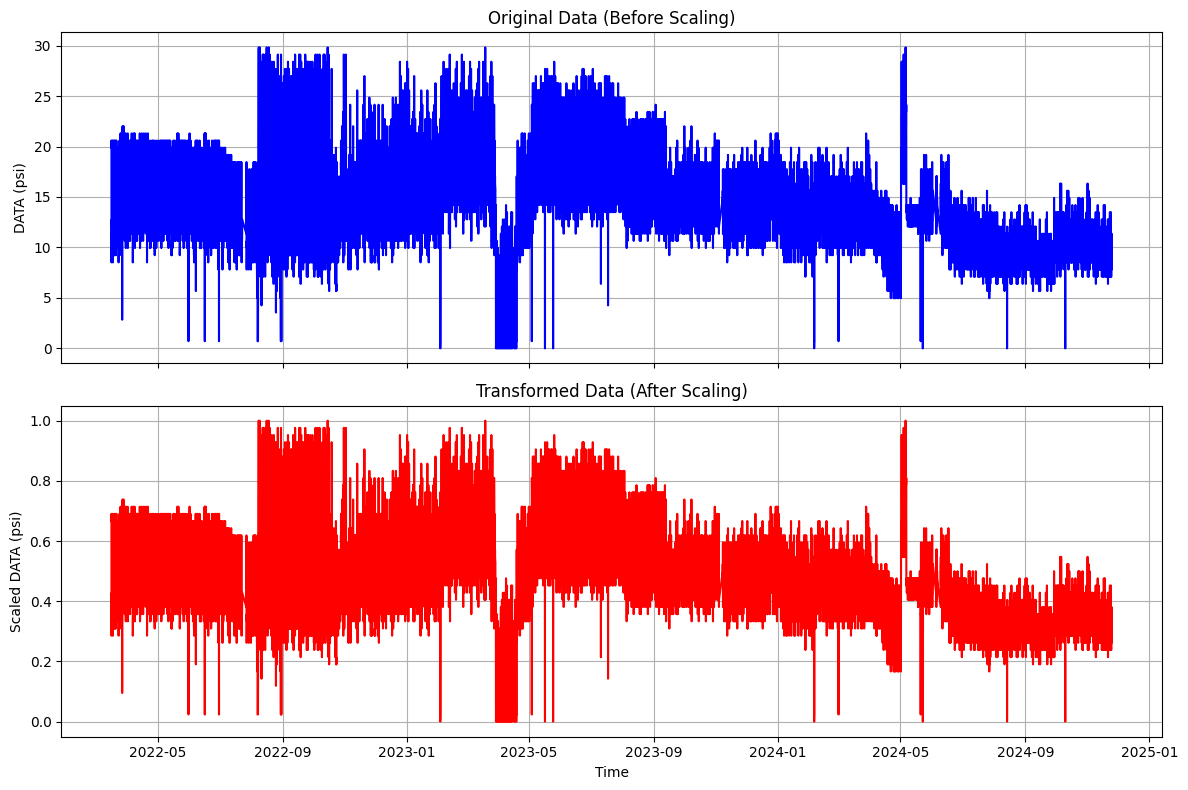

In [40]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot original data before scaling
axs[0].plot(df3_cleaned['DATE/TIME'], df3_cleaned['DATA (psi)'], color='blue')
axs[0].set_title('Original Data (Before Scaling)')
axs[0].set_ylabel('DATA (psi)')
axs[0].grid(True)

# Plot transformed data after scaling
axs[1].plot(data['DATE/TIME'], data['DATA (psi)'], color='red')
axs[1].set_title('Transformed Data (After Scaling)')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Scaled DATA (psi)')
axs[1].grid(True)

# Show the plots
plt.tight_layout()
plt.show()


In [41]:
#building model
model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(8, activation='elu'),
    Dense(1)  # Final output
])

# Compile model with Huber loss and Adam optimizer
model.compile(
    optimizer=Adam(learning_rate=0.005),
    loss=Huber(delta=1),
    metrics=['mae']
)

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Reduce LR if validation loss stops improving
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Model checkpoint to save the best model
model_checkpoint = ModelCheckpoint(
    filepath="best_lstm_modelv5.keras",
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr, model_checkpoint],
    verbose=1
)

Epoch 1/30


c:\Users\William\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2280/2280 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0019 - mae: 0.0372
Epoch 1: val_loss improved from inf to 0.00029, saving model to best_lstm_modelv5.keras
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 135s 58ms/step - loss: 0.0019 - mae: 0.0372 - val_loss: 2.8890e-04 - val_mae: 0.0186 - learning_rate: 0.0050
Epoch 2/30
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 7.1114e-04 - mae: 0.0237
Epoch 2: val_loss did not improve from 0.00029
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 111s 49ms/step - loss: 7.1112e-04 - mae: 0.0237 - val_loss: 3.3818e-04 - val_mae: 0.0209 - learning_rate: 0.0050
Epoch 3/30
2279/2280 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 6.2857e-04 - mae: 0.0226
Epoch 3: val_loss improved from 0.00029 to 0.00021, saving model to best_lstm_modelv5.keras
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 114s 50ms/step - loss: 6.2859e-04 - mae: 0.0226 - val_loss: 2.0811e-04 - val_mae: 0.0132 - learning_rate: 0.0050
Epoch 4/30
2280/2280 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 6.3394e-04 - mae: 0.0222
Epoch 4:

570/570 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step


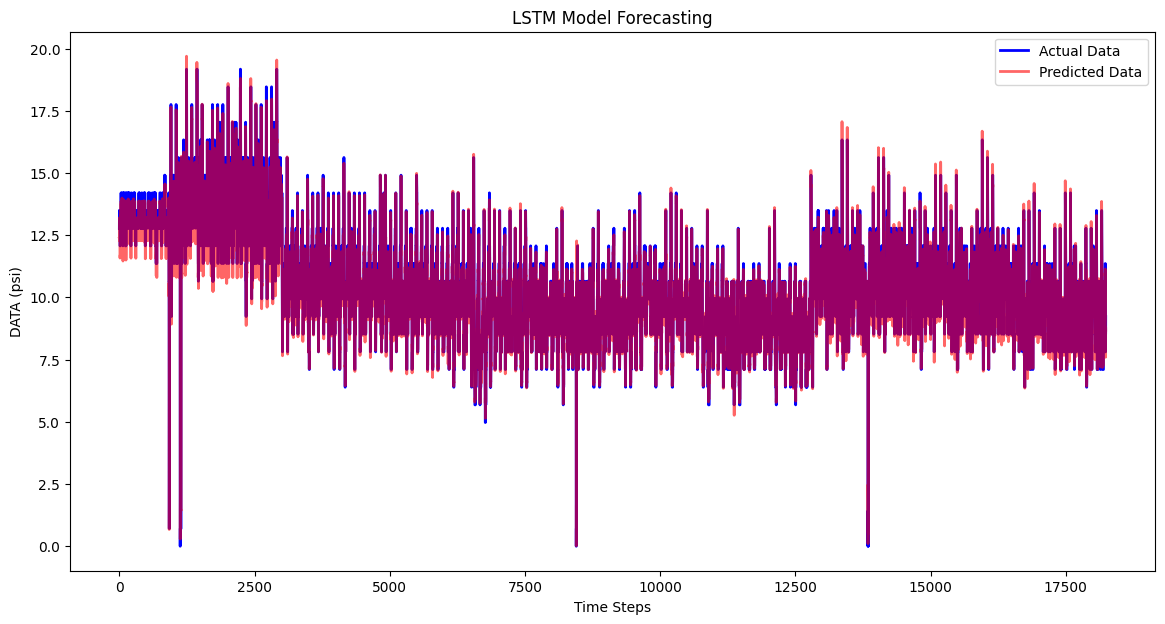

In [44]:
#checking the prediction
from tensorflow.keras.models import load_model

# Load the best saved model
best_model = load_model("best_lstm_modelv5.keras")

y_pred = best_model.predict(X_test)

y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_actual = scaler.inverse_transform(y_pred.reshape(-1, 1))

import matplotlib.pyplot as plt
import numpy as np

# Create time indices for plotting
time_index = np.arange(len(y_test_actual))

plt.figure(figsize=(14, 7))
plt.plot(time_index, y_test_actual, label="Actual Data", color="blue", linewidth=2)
plt.plot(time_index, y_pred_actual, label="Predicted Data", color="red", linewidth=2, alpha=0.6)

plt.title("LSTM Model Forecasting")
plt.xlabel("Time Steps")
plt.ylabel("DATA (psi)")
plt.legend()
plt.show()



In [45]:
#accuracy checking
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

# Calculate SMAPE
smape_value = smape(y_test_actual, y_pred_actual)
print(f"SMAPE: {smape_value:.2f}%")

accuracy = 100 - smape_value
print(f"Model Accuracy: {accuracy:.2f}%")

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test_actual, y_pred_actual)
print(f'MAE: {mae:.4f}')

from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))
print(f'RMSE: {rmse:.4f}')


SMAPE: 3.89%
Model Accuracy: 96.11%
MAE: 0.3936
RMSE: 0.6084
